# Pore size distribution

Often, pore size distributions are a very important part of adsorbent characterisation. The pyGAPS framework includes several common classical methods which are applicable to mesoporous or microporous materials. A DFT-fitting method is also provided together with an internal N2/carbon applicable DFT kernel. The user can also specify their own DFT kernel.

A complete aplicability guide and info on each function parameters can be found in the [manual](../manual/characterisation.rst).

First, make sure the data is imported.

In [1]:
%run import.ipynb

Selected 5 isotherms with nitrogen at 77K
Selected 2 room temperature calorimetry isotherms
Selected 2 isotherms for IAST calculation
Selected 3 isotherms for isosteric enthalpy calculation


## Mesoporous pore size distribution

Let's start by analysing the mesoporous size distribution of some of our nitrogen physisorption samples.

The MCM-41 sample should have a very well defined, singular pore size in the mesopore range, with the pores as open-ended cylinders. We can use a common method, relying on a description of the adsorbate in the pores based on the Kelvin equation and the thickness of the adsorbed layer. These methods are derivatives of the BJH (Barrett, Joyner and Halenda) method.

MCM-41


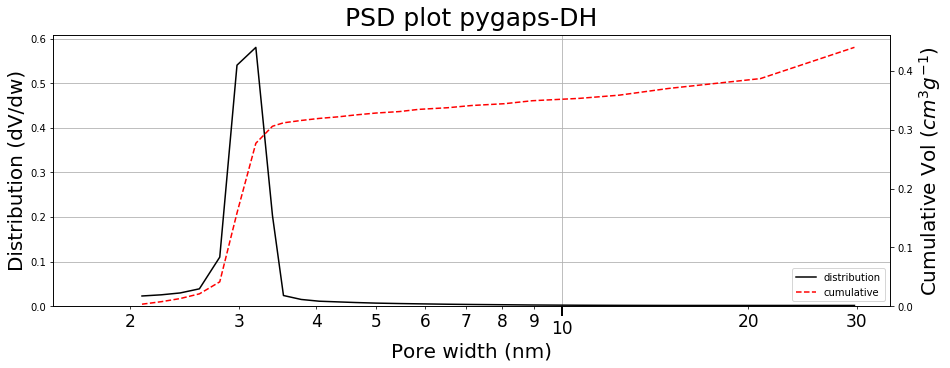

In [2]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='MCM-41')
print(isotherm.material)
result_dict = pygaps.psd_mesoporous(
    isotherm,
    pore_geometry='cylinder',
    verbose=True)

The distribution is what we expected, a single narrow peak. Since we asked for extra verbosity, the function has generated a graph which we can display with `plt.show()`. The graph automaticaly sets a minimum limit of 1.5 angstrom, where the Kelvin equation methods break down.

The result dictionary returned contains the x and y points of the graph.

Depending on the sample, the distribution can be a well defined or broad, single or multimodal, or, in the case of adsorbents without mesoporoes, not relevant at all. For example, using the Takeda 5A carbon, and specifying a slit pore geometry: 

Takeda 5A


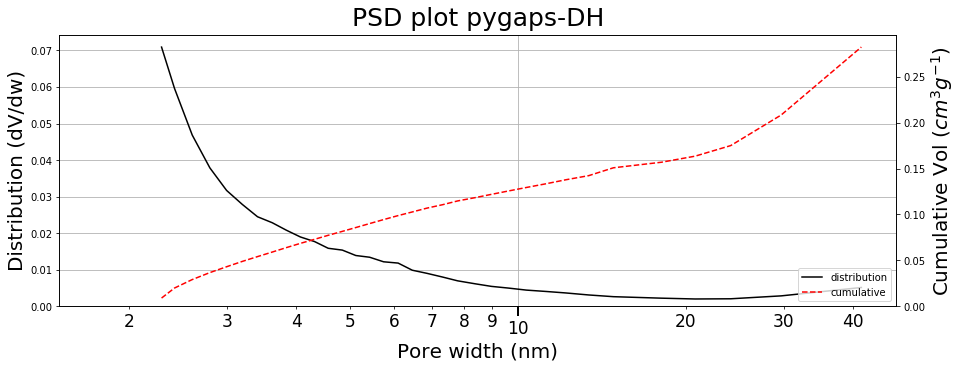

In [3]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='Takeda 5A')
print(isotherm.material)
result_dict_meso = pygaps.psd_mesoporous(
        isotherm,
        psd_model='pygaps-DH',
        pore_geometry='slit',
        verbose=True)

Now let's break down the available settings with the mesoporous PSD function.

- A `psd_model` parameter to select specific implementations of the methods, such as the original BJH method or the DH method.
- A `pore_geometry` parameter can be used to specify the known pore geometry of the pore. The Kelvin equation parameters change appropriately.
- Classical models are commonly applied on the desorption branch of the isotherm. This is also the default in this code, although the user can specify the adsorption branch to be used with the `branch` parameter.
- The function used for evaluating the layer thickness can be specified by the `thickness_model` parameter. Either a named internal model ('Halsey', 'Harkins/Jura', etc.) or a cusom user function which takes pressure as an argument is accepted.
- If the user wants to use a custom function for the Kelvin model, they can do so through the `kelvin_model` parameters. This must be a name of an internal model ('Kelvin', 'Kelvin-KJS', etc.) or a custom function.

Below we use the adsorption branch and the Halsey thickness curve to look at the MCM-41 pores. We use the Kruck-Jaroniec-Sayari correction of the Kelvin model.

MCM-41


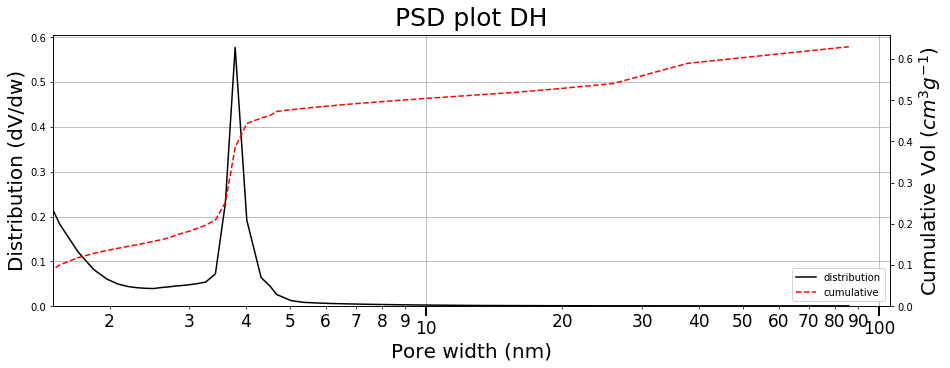

In [4]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='MCM-41')
print(isotherm.material)
result_dict = pygaps.psd_mesoporous(
    isotherm,
    psd_model='DH',
    pore_geometry='cylinder',
    branch='ads',
    thickness_model='Halsey',
    kelvin_model='Kelvin-KJS',
    verbose=True)

<div class="alert alert-info">

**Note:** If the user wants to customise the standard plots which are displayed, they are available for use in the `pygaps.graphing.calcgraph` module

</div>

## Microporous pore size distribution

For microporous samples, we can use the `psd_microporous` function. The available model is an implementation of the Horvath-Kawazoe (HK) method.

The HK model uses a list of parameters which describe the interaction between the adsorbate and the adsorbent. These should be selected on a *per case* basis by using the `adsorbate_model` and `adsorbent_model` keywords. If they are not specified, the function assumes a carbon model for the sample surface and takes the required adsorbate properties (*magnetic susceptibility, polarizability, molecular diameter, surface density, liquid density and molar mass*) from the specific internal adsorbate. The pore geometry is also assumed to be *slit-like*.

Let's look at using the function on the carbon sample:

Takeda 5A


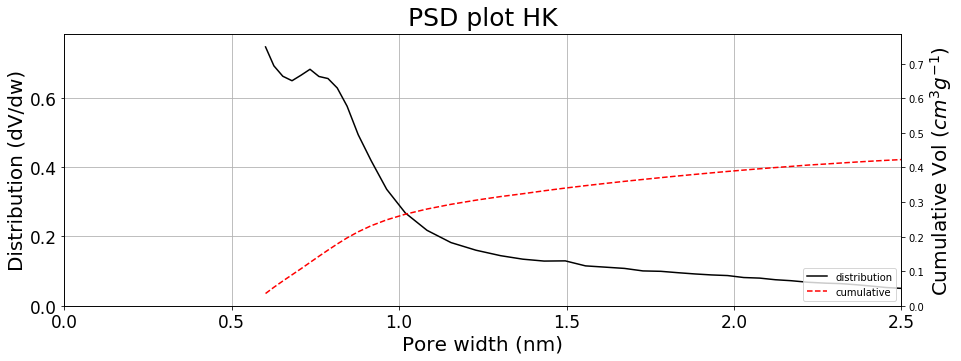

In [5]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='Takeda 5A')
print(isotherm.material)
result_dict_micro = pygaps.psd_microporous(
    isotherm,
    psd_model='HK',
    verbose=True)

We see that we could have a peak around 0.7 nm, but could use more adsorption data at low pressure for better resolution. It should be noted that the model breaks down with pores bigger than around 3 nm.

The framework comes with other models for the surface, like as the Saito-Foley derived oxide-ion model. Below is an attempt to use the HK method with these parameters for the UiO-66 sample and some user-specified parameters for the adsorbate interaction. We should not expect the results to be very accurate, due to the different surface properties and heterogeneity of the MOF.

UiO-66(Zr)


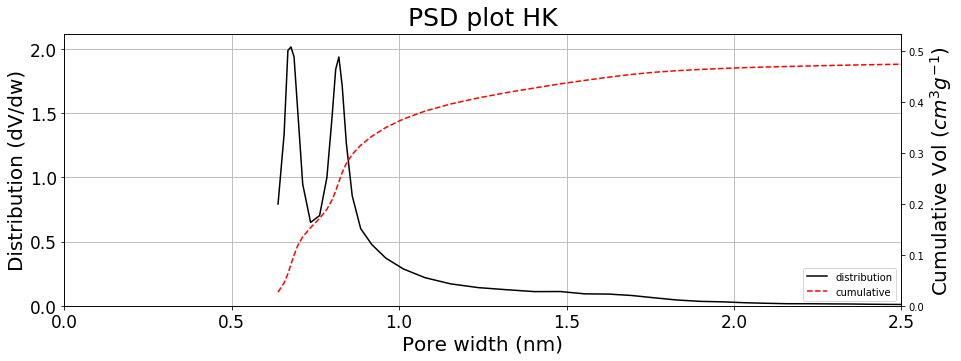

In [6]:
adsorbate_params = {
    'molecular_diameter': 0.3,
    'polarizability': 1.76e-3,
    'magnetic_susceptibility': 3.6e-8,
    'surface_density': 6.71e+18,
    'liquid_density': 0.806,
    'adsorbate_molar_mass': 28.0134
}

isotherm = next(i for i in isotherms_n2_77k if i.material=='UiO-66(Zr)')
print(isotherm.material)
result_dict = pygaps.psd_microporous(
    isotherm,
    psd_model='HK',
    adsorbent_model='AlSiOxideIon',
    adsorbate_model=adsorbate_params,
    verbose=True)

A bimodal pore size distribution is seen, with peaks at around 0.7 and 0.8 nanometers. UiO-66 does indeed have two cages, a tetrahedral cage and an octahedral one, with the sizes of 0.8 and 1.1 nm respectively.

## DFT pore size distribution

The DFT method is the most powerful method for pore size distribution calculations. It requires a *DFT kernel*, or a collection of previously simulated adsorption isotherms which cover the entire pore range which we want to investigate. The calculation of the DFT kernel is currently *not* in the scope of this framework.

The user can specify their own kernel, in a CSV format, which will be used for the isotherm fitting on the `psd_dft` function. Alternatively, a common DFT kernel is included with the framework, which is 
simulated with nitrogen on a carbon material and slit-like pores in the range of 0.4-10 nanometres.

Let's run the fitting of this internal kernel on the carbon sample:

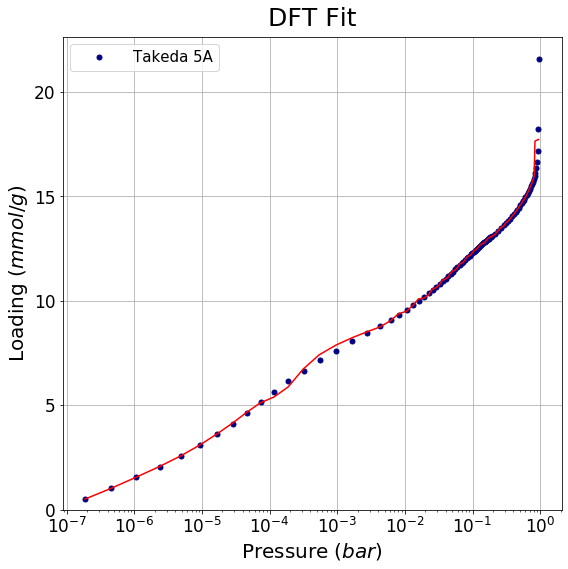

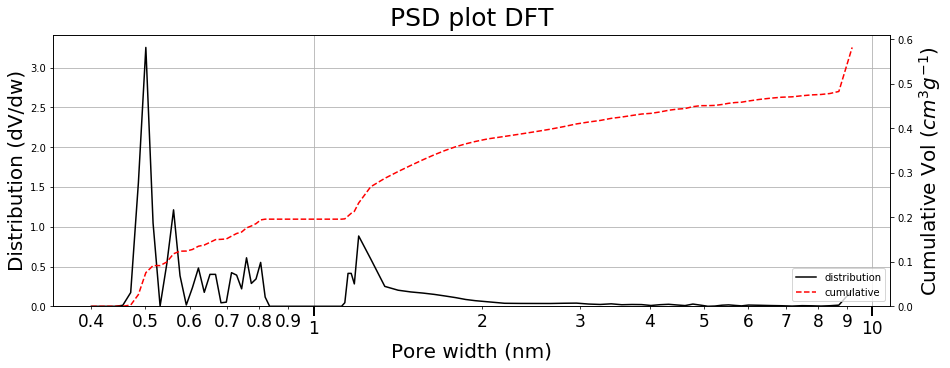

In [7]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='Takeda 5A')
result_dict_dft = pygaps.psd_dft(
    isotherm,
    kernel='DFT-N2-77K-carbon-slit',
    verbose=True)

The output is automatically smoothed using a b-spline method. Further (or less) smoothing can be specified by the `bspline_order` parameter. The higher the order, more smoothing is applied. Specify "0" to return the data *as-fitted*.

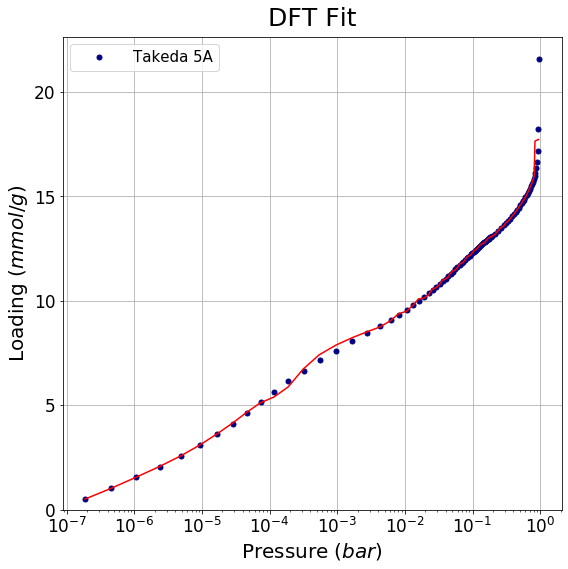

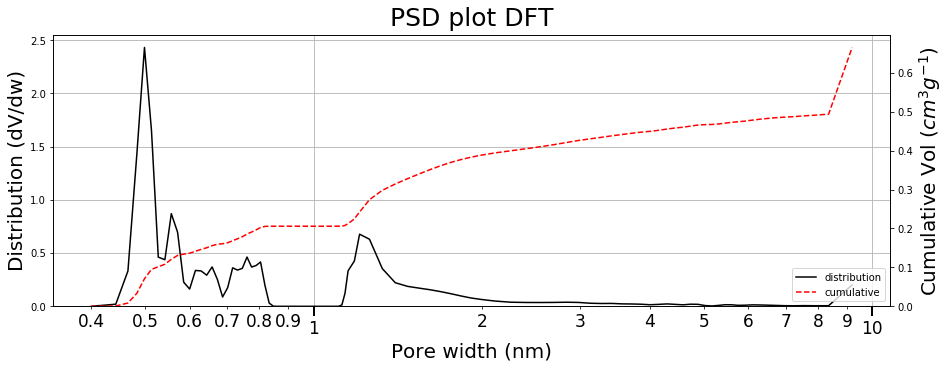

In [8]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='Takeda 5A')
result_dict_dft = pygaps.psd_dft(
    isotherm,
    bspline_order=5,
    verbose=True)


## Comparing all the PSD methods

For comparison purposes, we will compare the pore size distributions obtained through all the methods above. The sample on which all methods are applicable is the Takeda carbon.

We will first plot the data using the existing function plot, then use the graph returned to plot the remaining results. 

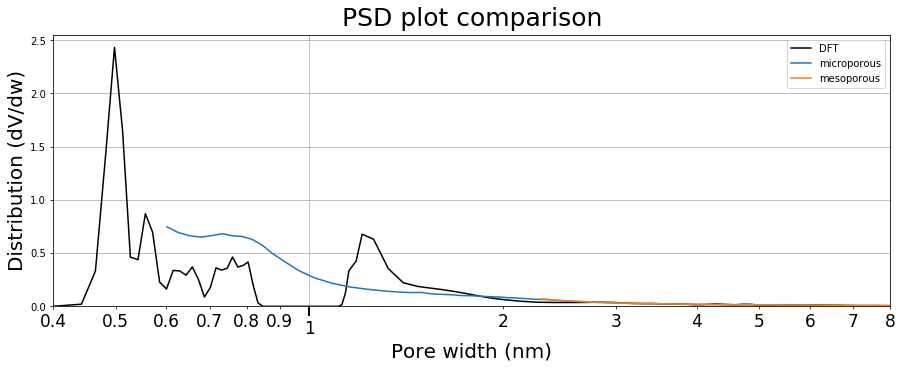

In [9]:
from pygaps.graphing.calcgraph import psd_plot

ax = psd_plot(result_dict_dft['pore_widths'], result_dict_dft['pore_distribution'],
              method='comparison', labeldiff='DFT', labelcum=None, left=0.4, right=8)
ax.plot(result_dict_micro['pore_widths'], result_dict_micro['pore_distribution'], label='microporous')
ax.plot(result_dict_meso['pore_widths'], result_dict_meso['pore_distribution'], label='mesoporous')

ax.legend(loc='best')

plt.show()